# GET POINT DATA INTO CSV FORMAT

In [26]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

from scipy.interpolate import NearestNDInterpolator
import scipy.io


Trace 2 points to get their spectrum 

In [41]:
def old_query_point(node_x, node_y, data_file, query_x, query_y):
    """Given a set of cell coordinates node_x, node_y, and a list of requested coordinates query_x, query_y,
    obtain the corresponding z values from the entire z array.
    """
    # Convert lists to numpy arrays if they are not already
    query_x = np.array(query_x)
    query_y = np.array(query_y)
    
    # Initialize lists to store results
    results = []
    
    # Tolerances - found with trial and error. 
    tolerance = 1e-4
    rtol = 1e-2
    
    for x, y in zip(query_x, query_y):
        queried_indices = np.where(
            np.isclose(node_x, x, atol=tolerance, rtol=rtol) &
            np.isclose(node_y, y, atol=tolerance, rtol=rtol)
        )
        results.append((queried_indices))
    return results


def query_point(node_x, node_y, query_x, query_y):
    DataInterpolant = NearestNDInterpolator(np.column_stack((node_x, node_y)), np.arange(len(node_x)))
    # Get nearest indices
    NearestIndices = DataInterpolant(query_x, query_y)
    return NearestIndices


def get_z_for_datafile(data_file):
    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]
        a = f['/settings/Common/'][:]  
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])
    return U, V, T, flowtime, timestep

def get_query_point_from_datafile(indices, data_file, query_x, query_y):

    U, V, T, flowtime, timestep = get_z_for_datafile(data_file)

    results = []
    for queried_indices in indices:
        queried_indices = queried_indices.astype(int)
        close_x = np.nanmean(node_x[queried_indices])
        close_y = np.nanmean(node_y[queried_indices])
        close_U = np.nanmean(U[queried_indices])
        close_V = np.nanmean(V[queried_indices])
        close_T = np.nanmean(T [queried_indices])
        #results.append((queried_indices, close_x, close_y, close_z1, close_z2, close_z3, timestep, flowtime))
        results.append((close_U, close_V, close_T, timestep, flowtime))
    return results


    #queried_indices, close_x, close_y, close_u = query_point(node_x, node_y, U, query_x, query_y)
    #queried_indices, close_x, close_y, close_v = query_point(node_x, node_y, V, query_x, query_y)

    return results

    
def get_nodes_from_casefile(data_folder):

    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
        return node_x, node_y

In [23]:
data_folder = "/Volumes/ThermalAmp/Tr2.5/"
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]


In [42]:
# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    try:
        return float(data_file.split(".")[0].split("-")[-1])  #My directories
        #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    except:
        return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)

query_x = [0.1, 0.005]
query_y = [-0.01, 0.01]

indices = query_point(node_x, node_y, query_x, query_y)

# Test for 1 data file
get_query_point_from_datafile(indices, data_files[-1], query_x, query_y)


[(np.float64(0.001018690647128298),
  np.float64(0.001390053772299095),
  np.float64(304.74781208152683),
  30000.0,
  1500.0),
 (np.float64(-0.011233759697789501),
  np.float64(0.02243048897320076),
  np.float64(302.34776887400074),
  30000.0,
  1500.0)]

In [61]:
fnames = [

'/Volumes/ThermalAmp/Tr1-NoCyl/',
    '/Volumes/ThermalAmp/Tr0.4/',
    '/Volumes/ThermalAmp/Tr0.8/',
    '/Volumes/ThermalAmp/Tr1/',
    '/Volumes/ThermalAmp/Tr1-4/',
    '/Volumes/ThermalAmp/TR1-6/',
    '/Volumes/ThermalAmp/Tr1.8/',
    '/Volumes/ThermalAmp/Tr1.9/',
    #'/Volumes/ThermalAmp/Tr2.3/',
    #'/Volumes/ThermalAmp/Tr2.5/',
    #'/Volumes/ThermalAmp/Tr2.9/',
    #'/Volumes/ThermalAmp/Tr3.5/',
    #'/Volumes/ThermalAmp/Tr=4/'
    
][::-1]

cases = [
    'NC', 0.4,0.8,1.0,1.4,1.6,1.8,1.9,#2.3,2.5,2.9,3.5,#4
][::-1]


In [62]:
fnames[0]

'/Volumes/ThermalAmp/Tr1.9/'

In [63]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning

use_parallel = False
for i, Tr in enumerate(cases):

    print("Starting {}".format(Tr))
    
    case_files = [fnames[i]+f for f in os.listdir(fnames[i]) if f.endswith('.cas.post')]
    case_files = [f for f in case_files if "/._" not in f]
    fname = os.path.join(fnames[i], case_files[0])
    # Read the mesh data from the HDF5 file
    with h5py.File(fname, 'r') as f:
        vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
    
    # Extract NodeX and NodeY
    node_x = vertex_list[0]
    node_y = vertex_list[1]

    # Find *dat.post files
    data_files = [fnames[i]+f for f in os.listdir(fnames[i]) if f.endswith('.dat.post')]
    data_files = [f for f in data_files if "/._" not in f]
    
    def get_time(data_file):
        try:
            return float(data_file.split(".")[0].split("-")[-1])  #My directories
            #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
        except:
            return float(data_file.split(".")[1].split("-")[-1])
    
    data_files = sorted(data_files, key=get_time)
    query_x = [0.1, 0.005]
    query_y = [-0.01, 0.01]

    if '30000' in data_files[-1001]:
        dats = data_files[3999:-1001]
    else:
        dats = data_files[0:10000]

    indices = query_point(node_x, node_y, query_x, query_y)

    if use_parallel:
        print(data_files[0])
        # Use LokyBackend to protect the h5py routine
        timeseries_results = Parallel(n_jobs=-1, backend='loky', verbose=1) \
        (delayed(get_query_point_from_datafile) \
         (indices, data_file, query_x, query_y
         ) for data_file in dats)
        timeseries_results_array = np.array(timeseries_results, dtype=object)
    else:
        timeseries_results = []
        for j, data_file in enumerate(dats):
            timeseries_results.append(get_query_point_from_datafile(indices, data_file, query_x, query_y))
            if j in np.arange(0,10001,100):
                print("Done {}".format(data_file))
    timeseries_results_array = np.array(timeseries_results, dtype=object)

    dat_out = np.column_stack(
        (
            timeseries_results_array[:,:,0], #plumeU
            timeseries_results_array[:,:,1], #plumeV
            timeseries_results_array[:,:,2], #plumeT
            timeseries_results_array[:,:,3][:,0], #timesteps
            timeseries_results_array[:,:,4][:,0], #flowtimes
        )
    )
    datt = pd.DataFrame(dat_out, columns=["plumeU", "vortU", "plumeV", "vortV", "plumeT", "vortT", "plumetstep", "flowt"])
    datt.to_csv("/Volumes/ThermalAmp/NewDataSeries/Tr{}.csv".format(Tr))

    del timeseries_results_array, dat_out, datt

env: PYTHONWARNINGS=ignore::UserWarning
Starting 1.9
Done /Volumes/ThermalAmp/Tr1.9/M4-10002.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-10202.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-10402.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-10602.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-10802.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-11002.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-11202.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-11402.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-11602.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-11802.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-12002.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-12202.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-12402.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-12602.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-12802.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-13002.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-13202.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-13402.dat.post
Done /Volumes/ThermalAmp/Tr1.9/M4-13602.dat.post
Done /Volumes/Th

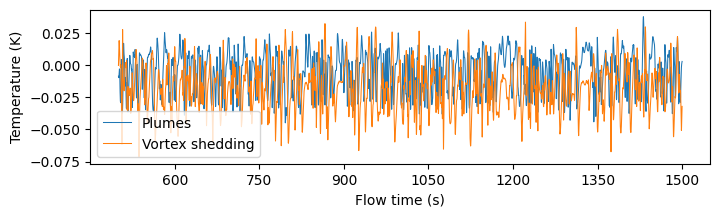

In [10]:
from matplotlib.ticker import MaxNLocator

pdf = pd.read_csv("/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format(1.8))


fig, ax = plt.subplots(figsize=(8,2))

ax.plot(pdf['flowt'].to_numpy(), pdf['plumeT'].to_numpy(), linewidth=0.75, label="Plumes")
ax.plot(pdf['flowt'].to_numpy(), pdf['vortT'].to_numpy(), linewidth=0.75, label="Vortex shedding")
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax.set_xlabel("Flow time (s)")
ax.set_ylabel("Temperature (K)")

ax.legend()
